# Experiment

Run experiment comparing different robust loss functions for single MLP model.

### Setup

In [1]:
import sys

sys.path.append(r"..")

In [60]:
import joblib
import numpy as np
import pandas as pd
import wandb
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import tensorflow as tf
from wandb.keras import WandbCallback

from src.plotting import plot_hardness
from src.metrics import regression_report, regression_score
from src.losses import AdaptiveLoss

In [9]:
plt.rcParams["figure.figsize"] = (16, 10)

### Data

In [3]:
train_df = pd.read_csv(r"../data/train.csv")
validation_df = pd.read_csv(r"../data/validation.csv")
test_df = pd.read_csv(r"../data/test.csv")

feature_preprocessor = joblib.load(r"../models/feature_preprocessor.joblib")
target_preprocessor = joblib.load(r"../models/target_preprocessor.joblib")

In [4]:
feature_columns = ["Distance", "Electric Current", "Speed", "Beads", "Bead Type Feature"]
target_columns = ["Hardness"]

### Plots

In [38]:
def apply_elementwise_loss_class(y_true, y_pred, loss):
    """Util for plotting loss functions"""
    return np.asarray([loss(tf.expand_dims(x, axis=0), tf.expand_dims(y, axis=0)) for x, y in zip(y_true, y_pred)])

In [39]:
mse = tf.keras.losses.MeanSquaredError()
log_cosh = tf.keras.losses.LogCosh()
huber_04 = tf.keras.losses.Huber(0.4)
huber_08 = tf.keras.losses.Huber(0.8)

In [41]:
x = np.linspace(-2.5, 2.5, 1000)
ground = np.zeros(1000)

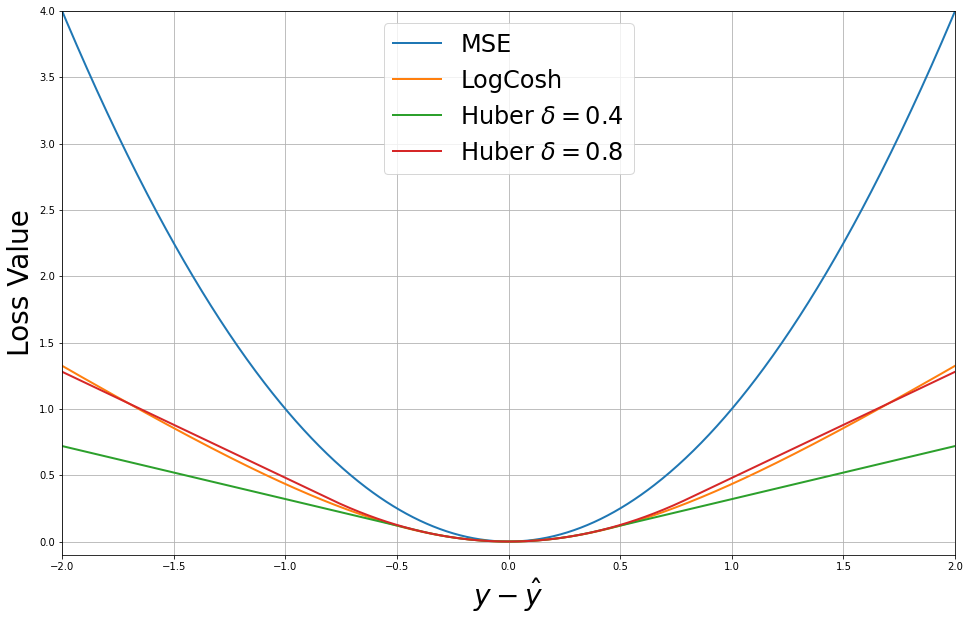

In [43]:
_ = plt.figure(figsize=[16, 10])

_ = plt.plot(x, apply_elementwise_loss_class(ground, x, mse), linewidth=2.0)
_ = plt.plot(x, apply_elementwise_loss_class(ground, x, log_cosh), linewidth=2.0)
_ = plt.plot(x, apply_elementwise_loss_class(ground, x, huber_04), linewidth=2.0)
_ = plt.plot(x, apply_elementwise_loss_class(ground, x, huber_08), linewidth=2.0)

_ = plt.legend(["MSE", "LogCosh", "Huber $\delta=0.4$", "Huber $\delta=0.8$"], loc="upper center", fontsize=24)
_ = plt.grid()
_ = plt.xlim([-2, 2])
_ = plt.ylim([-0.1, 4])
_ = plt.xlabel("$y - \hat{y}$", fontsize=28)
_ = plt.ylabel("Loss Value", fontsize=28)
_ = plt.savefig("../plots/loss-functions.png", bbox_inches="tight")

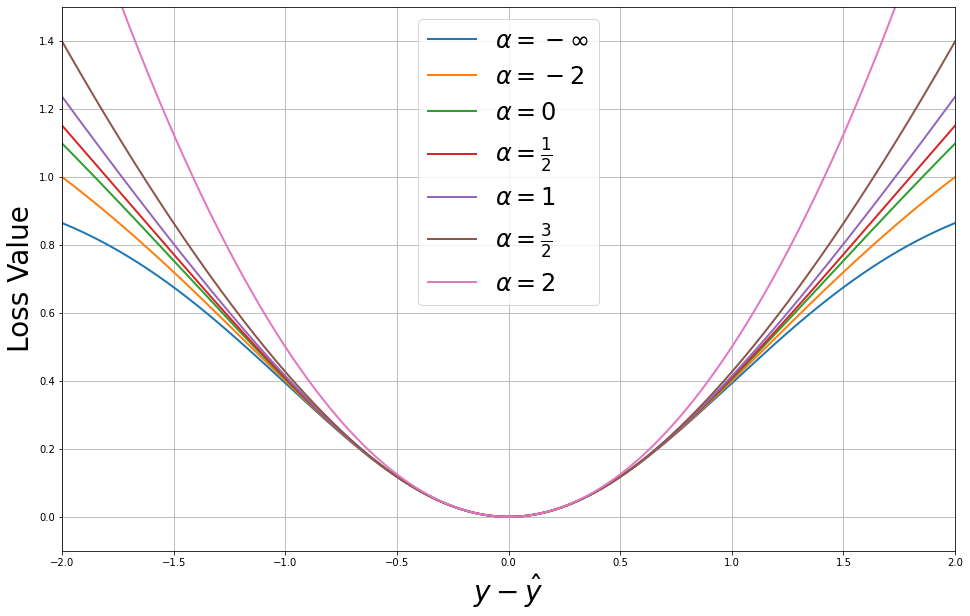

In [61]:
_ = plt.figure(figsize=[16, 10])

for alpha in [-np.inf, -2.0, 0.0, 0.5, 1.0, 1.5, 2.0]:
    loss = AdaptiveLoss(alpha=alpha, scale=1)
    _ = plt.plot(x, apply_elementwise_loss_class(ground, x, loss), linewidth=2.0)

_ = plt.legend([r"$\alpha=-\infty$", r"$\alpha=-2$", r"$\alpha=0$", r"$\alpha=\frac{1}{2}$", r"$\alpha=1$", r"$\alpha=\frac{3}{2}$", r"$\alpha=2$"], loc="upper center", fontsize=24)
_ = plt.grid()
_ = plt.xlim([-2, 2])
_ = plt.ylim([-0.1, 1.5])
_ = plt.xlabel("$y - \hat{y}$", fontsize=28)
_ = plt.ylabel("Loss Value", fontsize=28)
_ = plt.savefig("../plots/robust-loss-functions.png", bbox_inches="tight")

Create function to get base model. Chosen parameters are:
* 5 hidden layers
* 10 units in each hidden layer
* sigmoidal activations

In [5]:
def get_base_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(5,)))

    for _ in range(5):
        model.add(tf.keras.layers.Dense(10, activation="sigmoid"))

    model.add(tf.keras.layers.Dense(1, activation="linear"))
    
    return model


### MSE 

In [6]:
mse_model = get_base_model()
mse_model.compile(optimizer="rmsprop", loss="mse", metrics=["mse", "mae"])

In [7]:
fit_history = mse_model.fit(
    train_df[feature_columns].values,
    train_df[target_columns].values,
    epochs=1000,
    validation_split=0.1,
    verbose=0,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50)]
)

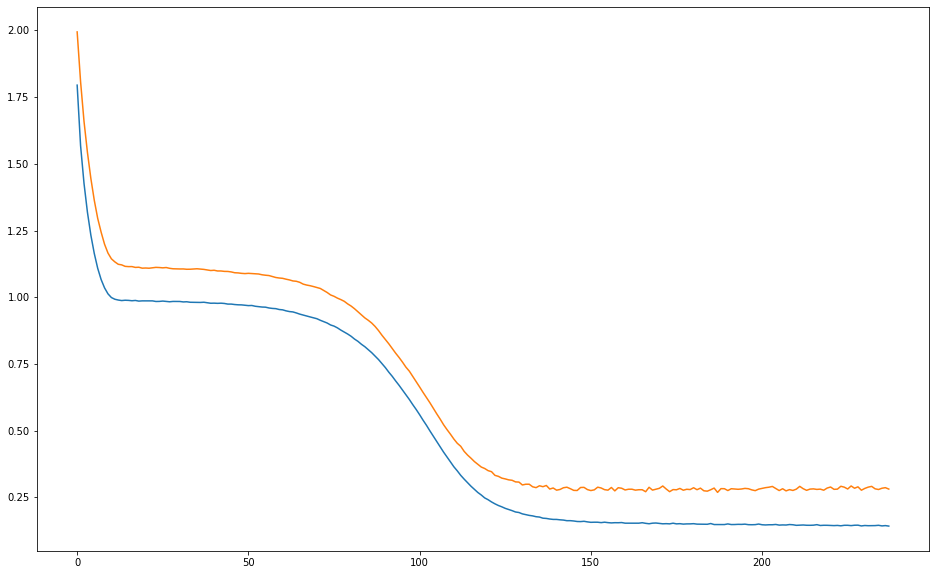

In [10]:
_ = plt.plot(np.arange(len(fit_history.history["loss"])), fit_history.history["loss"])
_ = plt.plot(np.arange(len(fit_history.history["val_loss"])), fit_history.history["val_loss"])

_ = plt.savefig(r"../plots/hardness-mse-mlp-fit-history.png", bbox_inches="tight")

In [25]:
predictions = mse_model.predict(validation_df[feature_columns].values)
predicted_hardness = target_preprocessor.inverse_transform(predictions)

print(regression_report(y_true=validation_df[target_columns].values.flatten(), y_pred=predicted_hardness.flatten(), precision=3))

                                Absolute                        Normalized                      

Mean Squared Error:             5347.275                        0.107                           
Root Mean Squared Error:        73.125                          0.221                           
Mean Absolute Error:            49.986                          0.221                           
Median Absolute Error:          26.163                          0.119                           
Max Error:                      240.569                         0.383                           
R2                                                              0.786                           


                                True                            Predicted                       

Mean:                           239.808                         250.412                         
std:                            158.217                         142.337                         



In [24]:
predictions = mse_model.predict(test_df[feature_columns].values)
predicted_hardness = target_preprocessor.inverse_transform(predictions)

print(regression_report(y_true=test_df[target_columns].values.flatten(), y_pred=predicted_hardness.flatten(), precision=3))

                                Absolute                        Normalized                      

Mean Squared Error:             5374.709                        0.051                           
Root Mean Squared Error:        73.312                          0.159                           
Mean Absolute Error:            47.539                          0.159                           
Median Absolute Error:          22.814                          0.109                           
Max Error:                      239.097                         0.419                           
R2                                                              0.828                           


                                True                            Predicted                       

Mean:                           305.456                         287.936                         
std:                            176.810                         162.513                         



### LogCosh

Use other loss function, details of the experiment setup are described in the paper.

In [27]:
log_cosh_model = get_base_model()
log_cosh_model.compile(optimizer="rmsprop", loss=tf.keras.losses.LogCosh(), metrics=["mse", "mae"])

In [28]:
fit_history = log_cosh_model.fit(
    train_df[feature_columns].values,
    train_df[target_columns].values,
    epochs=1000,
    validation_split=0.1,
    verbose=0,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50)]
)

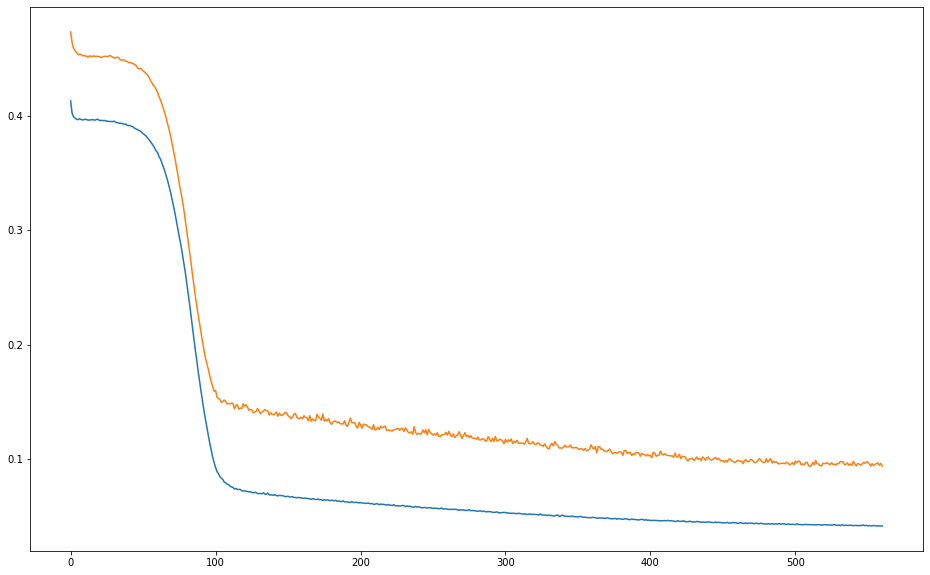

In [29]:
_ = plt.plot(np.arange(len(fit_history.history["loss"])), fit_history.history["loss"])
_ = plt.plot(np.arange(len(fit_history.history["val_loss"])), fit_history.history["val_loss"])

_ = plt.savefig(r"../plots/hardness-log-cosh-mlp-fit-history.png", bbox_inches="tight")

In [30]:
predictions = log_cosh_model.predict(validation_df[feature_columns].values)
predicted_hardness = target_preprocessor.inverse_transform(predictions)

print(regression_report(y_true=validation_df[target_columns].values.flatten(), y_pred=predicted_hardness.flatten(), precision=3))

                                Absolute                        Normalized                      

Mean Squared Error:             5429.496                        0.087                           
Root Mean Squared Error:        73.685                          0.174                           
Mean Absolute Error:            43.066                          0.174                           
Median Absolute Error:          15.876                          0.086                           
Max Error:                      266.070                         0.424                           
R2                                                              0.783                           


                                True                            Predicted                       

Mean:                           239.808                         242.274                         
std:                            158.217                         147.677                         



In [32]:
predictions = log_cosh_model.predict(test_df[feature_columns].values)
predicted_hardness = target_preprocessor.inverse_transform(predictions)

print(regression_report(y_true=test_df[target_columns].values.flatten(), y_pred=predicted_hardness.flatten(), precision=3))

                                Absolute                        Normalized                      

Mean Squared Error:             6235.966                        0.046                           
Root Mean Squared Error:        78.968                          0.133                           
Mean Absolute Error:            43.803                          0.133                           
Median Absolute Error:          17.877                          0.079                           
Max Error:                      304.767                         0.535                           
R2                                                              0.801                           


                                True                            Predicted                       

Mean:                           305.456                         283.115                         
std:                            176.810                         167.626                         



### Huber Loss

10 runs were conducted, value of 0.4 for parameter `delta` was chosen.

In [33]:
huber_model = get_base_model()
huber_model.compile(optimizer="rmsprop", loss=tf.keras.losses.Huber(0.4), metrics=["mse", "mae"])

In [34]:
fit_history = huber_model.fit(
    train_df[feature_columns].values,
    train_df[target_columns].values,
    epochs=1000,
    validation_split=0.1,
    verbose=0,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50)]
)

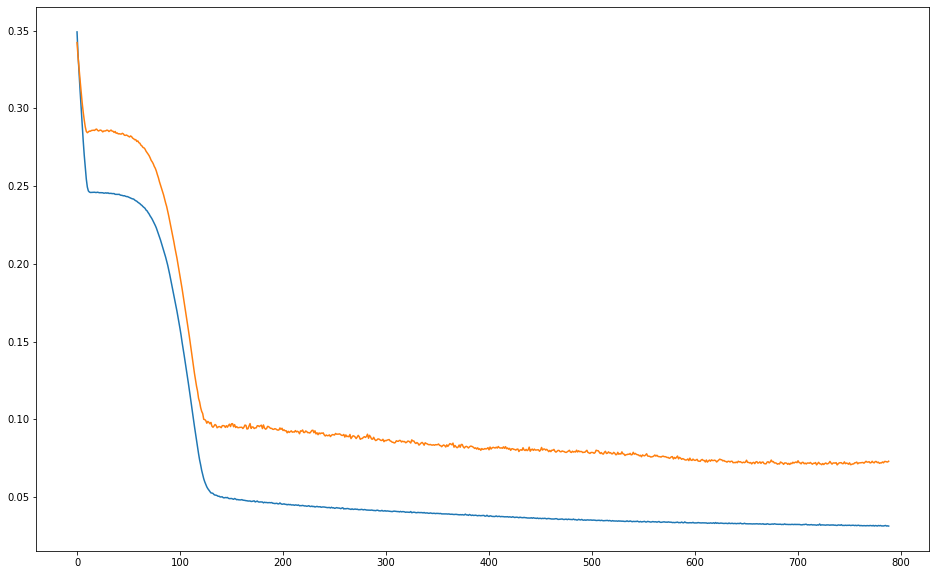

In [35]:
_ = plt.plot(np.arange(len(fit_history.history["loss"])), fit_history.history["loss"])
_ = plt.plot(np.arange(len(fit_history.history["val_loss"])), fit_history.history["val_loss"])

_ = plt.savefig(r"../plots/hardness-huber-mlp-fit-history.png", bbox_inches="tight")

In [36]:
predictions = huber_model.predict(validation_df[feature_columns].values)
predicted_hardness = target_preprocessor.inverse_transform(predictions)

print(regression_report(y_true=validation_df[target_columns].values.flatten(), y_pred=predicted_hardness.flatten(), precision=3))

                                Absolute                        Normalized                      

Mean Squared Error:             6101.663                        0.082                           
Root Mean Squared Error:        78.113                          0.163                           
Mean Absolute Error:            41.897                          0.163                           
Median Absolute Error:          14.753                          0.085                           
Max Error:                      343.204                         0.547                           
R2                                                              0.756                           


                                True                            Predicted                       

Mean:                           239.808                         241.298                         
std:                            158.217                         147.898                         



In [37]:
predictions = huber_model.predict(test_df[feature_columns].values)
predicted_hardness = target_preprocessor.inverse_transform(predictions)

print(regression_report(y_true=test_df[target_columns].values.flatten(), y_pred=predicted_hardness.flatten(), precision=3))

                                Absolute                        Normalized                      

Mean Squared Error:             8860.764                        0.044                           
Root Mean Squared Error:        94.132                          0.112                           
Mean Absolute Error:            44.425                          0.112                           
Median Absolute Error:          8.421                           0.044                           
Max Error:                      364.420                         0.639                           
R2                                                              0.717                           


                                True                            Predicted                       

Mean:                           305.456                         278.960                         
std:                            176.810                         167.953                         



### Adaptive Loss

In [62]:
adaptive_loss_model = get_base_model()
adaptive_loss_model.compile(optimizer="rmsprop", loss=AdaptiveLoss(alpha=1.5, scale=1.0), metrics=["mse", "mae"])

In [63]:
fit_history = adaptive_loss_model.fit(
    train_df[feature_columns].values,
    train_df[target_columns].values,
    epochs=1000,
    validation_split=0.1,
    verbose=0,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50)]
)

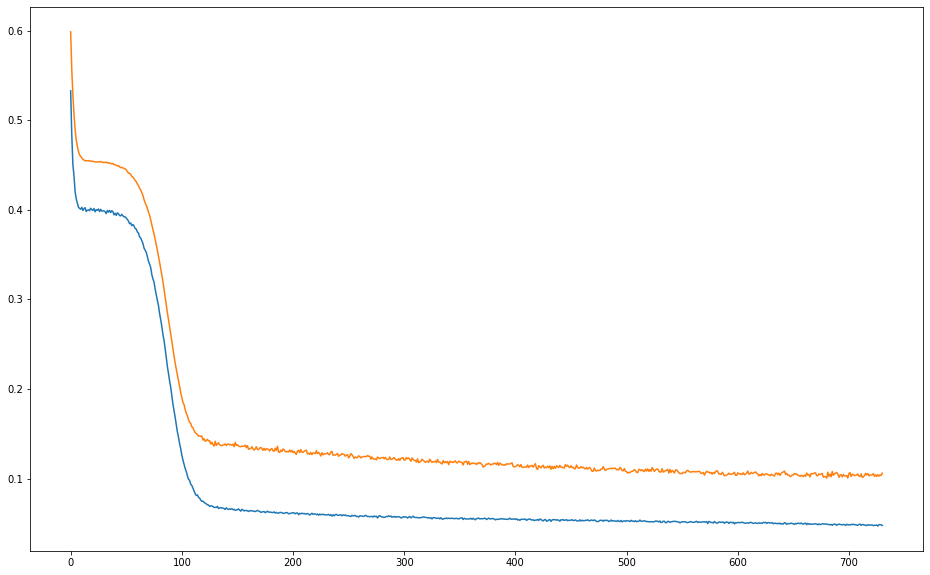

In [64]:
_ = plt.plot(np.arange(len(fit_history.history["loss"])), fit_history.history["loss"])
_ = plt.plot(np.arange(len(fit_history.history["val_loss"])), fit_history.history["val_loss"])

_ = plt.savefig(r"../plots/adaptive-loss-mlp-fit-history.png", bbox_inches="tight")

In [65]:
predictions = adaptive_loss_model.predict(validation_df[feature_columns].values)
predicted_hardness = target_preprocessor.inverse_transform(predictions)

print(regression_report(y_true=validation_df[target_columns].values.flatten(), y_pred=predicted_hardness.flatten(), precision=3))

                                Absolute                        Normalized                      

Mean Squared Error:             4909.445                        0.095                           
Root Mean Squared Error:        70.067                          0.173                           
Mean Absolute Error:            40.004                          0.173                           
Median Absolute Error:          15.366                          0.084                           
Max Error:                      272.066                         0.433                           
R2                                                              0.804                           


                                True                            Predicted                       

Mean:                           239.808                         250.732                         
std:                            158.217                         147.919                         



In [66]:
predictions = adaptive_loss_model.predict(test_df[feature_columns].values)
predicted_hardness = target_preprocessor.inverse_transform(predictions)

print(regression_report(y_true=test_df[target_columns].values.flatten(), y_pred=predicted_hardness.flatten(), precision=3))

                                Absolute                        Normalized                      

Mean Squared Error:             4369.122                        0.025                           
Root Mean Squared Error:        66.099                          0.092                           
Mean Absolute Error:            33.458                          0.092                           
Median Absolute Error:          11.509                          0.050                           
Max Error:                      267.446                         0.469                           
R2                                                              0.860                           


                                True                            Predicted                       

Mean:                           305.456                         287.227                         
std:                            176.810                         164.939                         

